# P4 - Anticipez les besoins en consommation électrique de bâtiments

## P4_02 - Modélisation Consommation d'énergie à Seattle

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from math import sqrt

%matplotlib inline
from sklearn.preprocessing import  RobustScaler ,MinMaxScaler
from sklearn.model_selection import train_test_split,cross_validate,
import sklearn.metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error , confusion_matrix,accuracy_score ,r2_score

from category_encoders import TargetEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
    
from sklearn.ensemble import  RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import time
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb



C:\Users\karim\anaconda3\envs\worklab\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index



## Introduction
_______________________________________________________________________________________________________________________________

**Mission**
_______________________________________________________________________________________________________________________________

- La ville de Seattle souhaite atteindre son objectif de neutralité carbone en 2050. Afin de ne pas subir de nouveaux coûts élevés, comme pour les relevés minutieux des campagnes effectuées en 2015 et 2016, la ville a besoin de prédictions pour les bâtiments non destinés à l'habitation.


 Les trois objectifs principaux fixés sont :


- prédire au moyen d'une modélisation :
   - leurs émissions de CO2 ou GES (Gaz à Effets de Serre),
   - la consommation totale d'énergie des bâtiments,
- Evaluer, pour ces prédictions, la pertinence d'un indicateur d'efficacité énergétique appelé Energy Star Score.


_______________________________________________________________________________________________________________________________

**Démarche**
_______________________________________________________________________________________________________________________________

- Préparation des données pour les rendre applicables aux modèles de machine learning :


- sépartion des données en entrées (matrice X) et de la variable cible (vecteur y).


- split du jeu de données en jeu d'entraînement (train) et jeu de test (test).


- préparation des variables quantitatives et qualitatives : encodage / standardisation?

_______________________________________________________________________________________________________________________________

**Modélisation**
_______________________________________________________________________________________________________________________________

Essayer plusieurs modèles en utilisant les hyperparamètres de base sur la variable cible transformée en log 

sélectionner les modèles avec de base.

recherche automatique à partir des premières intuitions pour trouver les hyperparamètres les plus performants :GridSearch CV

Sélectionner le modèle final le plus performant.


### Importation des données

In [2]:
# Chargement du jeu de données prédédemment nettoyé

data = pd.read_csv('data_clean3.csv', sep=",")

In [3]:
data.head()

,DataYear,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,...,ENERGYSTARScore,SiteEnergyUse(kBtu),Outlier,TotalGHGEmissions,BuildingAge,TotalUseTypesCount,Address_type,SiteEnergyUseLog,TotalGHGEmissionsLog,TauxParkingGFA
0,2015,NonResidential,Residential,7,DOWNTOWN,47.614114,-122.332741,1926,1.0,11.0,...,25.0,6252842.0,not,208.46,89,1,AVENUE,6.796078,2.321101,0.0
1,2015,SPS-District K-12,Education,3,CENTRAL,47.623094,-122.305389,1955,1.0,1.0,...,57.0,6283226.0,not,244.51,60,1,AVENUE,6.798183,2.390069,0.0
2,2015,SPS-District K-12,Education,7,MAGNOLIA / QUEEN ANNE,47.633032,-122.352457,1989,1.0,2.0,...,94.0,1472548.0,not,10.27,26,1,STREET,6.168070,1.051924,0.0
3,2015,NonResidential,Self-Storage Facility\n,4,NORTHEAST,47.662703,-122.296123,1955,1.0,2.0,...,77.0,306721.0,not,3.71,60,1,STREET,5.486745,0.673021,0.0
4,2015,SPS-District K-12,Education,7,MAGNOLIA / QUEEN ANNE,47.657262,-122.390651,1990,1.0,2.0,...,91.0,1655612.0,not,28.78,25,1,AVENUE,6.218959,1.473925,0.0


In [4]:
data.columns

Index(['DataYear', 'BuildingType', 'PrimaryPropertyType',
       'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude',
       'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFABuilding(s)', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
       'ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'Outlier',
       'TotalGHGEmissions', 'BuildingAge', 'TotalUseTypesCount',
       'Address_type', 'SiteEnergyUseLog', 'TotalGHGEmissionsLog',
       'TauxParkingGFA'],
      dtype='object')

In [4]:
# Copie du jeu de données dans un dataframe témoin

df=data.copy()


##  Pré-traitement des données

**Selection des données**

In [6]:
# Variables qualitatives
cols_cat =df.select_dtypes(exclude=[np.number]).columns.to_list()
cols_cat

['BuildingType',
 'PrimaryPropertyType',
 'CouncilDistrictCode',
 'Neighborhood',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'Outlier',
 'Address_type']

In [7]:
cols_cat=['BuildingType',
 #'PrimaryPropertyType',
 'CouncilDistrictCode',
 'Neighborhood',
 'LargestPropertyUseType',
 'Address_type']

In [8]:
# Variables quantitatives
cols_num = df.select_dtypes(include=[np.number]).columns.to_list()
cols_num 

['DataYear',
 'Latitude',
 'Longitude',
 'YearBuilt',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFABuilding(s)',
 'ENERGYSTARScore',
 'SiteEnergyUse(kBtu)',
 'TotalGHGEmissions',
 'BuildingAge',
 'TotalUseTypesCount',
 'SiteEnergyUseLog',
 'TotalGHGEmissionsLog',
 'TauxParkingGFA']

**Variables à prédire**

- SiteEnergyUse(kBtu) -> consommation totale d'énergie
- TotalGHGEmissions -> émissions de CO2

In [9]:
# Variables cibles
cols_target = ['SiteEnergyUse(kBtu)','TotalGHGEmissions','SiteEnergyUseLog','TotalGHGEmissionsLog']


In [10]:
# Suppression Variables cibles
# Suppression de la variable 'ENERGYSTARScore'
cols_num=['Latitude',
 'Longitude',
 'BuildingAge',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFABuilding(s)',
 'TotalUseTypesCount',
 'TauxParkingGFA']

In [11]:
# Matrice X
X = df[cols_cat+cols_num]
X.shape

(1402, 13)

### Prédiction SiteEnergyUse(kBtu)
Après avoir bien préparé les données, il est désormais possible de prédire la consommation d'un bâtiment par différents modèles de machine learning, les comparer et ainsi choisir le plus performant et le mieux adapté à nos données.

In [12]:
# Vecteur y

#On conserve les 2 cibles une transformée et l'autre non pour voir son efficacité sur la performance des modèles

# Analyse de la target 'SiteEnergyUseWN' non transformée
y = df['SiteEnergyUse(kBtu)']
y.shape

(1402,)

In [13]:
# Analyse de la target 'SiteEnergyUseWNLog' transformée en logarithme
y_log = df['SiteEnergyUseLog']
y_log.shape

(1402,)

### Transformation des données
#### Encodage Standardisation des variables

- Avant de passer à la modélisation , il est impératif de préparer les données en passant par les étapes suivantes :

   - encodage: convertir les variables catégoriales en données numériques
   - standardisation: il est important de normaliser les données et les mettre au même échelle pour rendre l'apprentissage de la machine plus rapide et aussi plus efficace.


In [14]:

  # Standardisation des variables quantitatives

scaler_rob = MinMaxScaler()
X[cols_num]= scaler_rob.fit_transform(X[cols_num].copy(deep=True))

X.shape

(1402, 13)

In [15]:
 # Encodage  des variables qualitatives
# Convertir une variable catégorielle en variables factices/indicatrices avec pandas.get_dummies
#X=pd.get_dummies(data=X, columns=cols_cat)

target_encoder = TargetEncoder()
X[cols_cat] = target_encoder.fit_transform(
    X[cols_cat], y)
X[cols_cat] = target_encoder.transform(X[cols_cat])

### Découpage du jeu de données en train set et test set

In [16]:
# Découpage du jeu de données en train set et test set cible non transformée ==>SiteEnergyUse(kBtu)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)


In [17]:
# Découpage du jeu de données en train set et test set cilble transformée 'SiteEnergyUseLog'
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42)


## Tester différents algorithmes de Machine Learning

### Les modeles utilisés 

- **Estimation par une régression par la méthode Lasso** 
La régression Lasso est une méthode de sélection de variables et de réduction de dimension supervisée en annulant certains coefficients (par la norme L1) : les variables qui ne sont pas nécessaires à la prédiction sont éliminées et ne font plus parties du modèle, qui sera simplifié. Les variables doivent être normalisées pour limiter les erreurs.


- **Estimation par la méthode Régression Ridge**
La régression linéaire multiple trouve les coefficients idéaux pour que les données prédites soient au plus proche des données réelles. La Régression Ridge permet de limiter les coefficients extrêmes que peut trouver la régression linéaire et ainsi limiter le sur-apprentissage (limiter les erreurs du modèle et la complexité du modèle grâce à la norme L2).


- **Estimation par une régression par la méthode Random Forest** 
La méthode de ramdom_forest utilise un ensemble d'arbres de décision multiples comme modèle d'apprentissage pour déterminer le résultat final. Chaque arbre est formé à partir d'un échantillon et de nouvelles caractéristiques à chaque noeud de l'arbre.

La valeur de la prédiction correspond à la moyenne de tous les arbres de la "forêt'.
 
 
- **Estimation par une régression par la méthode XGBoost** 
C’est une méthode ensembliste qui fait partie de la famille des algorithmes de boosting qui se base sur les arbres de décision et qui utilise plus particulièrement le boosting de gradient.
Cet algorithme construit un modèle faible qui donne de très mauvais résultats, il tire des conclusions sur les erreurs qui existent entre la prédiction et la réalité. A partir de ces conclusions et des conditions prises lors de la création du premier arbre, il va construire un modèle plus solide en tentant de réduire l'erreur de prédiction du modèle précédent (prédiction des erreurs en donnant un poids élevé aux mauvaises prédictions de l'arbre précédent pour ne plus la refaire). Il s'agit ici d'un système itératif car la formation de l'arbre au temps T à besoin que l'arbre T-1 soit formé pour pouvoir prédire et améliorer les erreurs sur le modèle.


- **Estimation par une régression par la méthode Gradient Boosting regressor**
GB construit un modèle additif de manière progressive; il permet l'optimisation de fonctions de perte différentiables arbitraires. À chaque étape, un arbre de régression est ajusté sur le gradient négatif de la fonction de perte donnée.


### Comparaison des méthodes

Pour la comparaison des methodes on vas baser sur : 


- Le RMSE (root mean squared error) fournit une indication sur la variance du modèle prédit. Plus précisément, il caractérise la taille des écarts entre observations et les mesures. Les valeurs du RMSE sont comprises entre [0;+∞[. Plus la valeur du critère RMSE est proche de zéro, meilleur est le modèle évalué en terme d’exactitude. Il faut donc minimiser la valeur du RMSE et choisir un modèle avec le RMSE le plus faible pour avoir un modèle qui se rapproche le plus des valeurs réelles.

- MSE (Mean Square Error )Le carré moyen des erreurs  : c’est la moyenne arithmétique des carrés des écarts entre prévisions du modèle et observations.C’est la valeur à minimiser dans le cadre d’une régression simple ou multiple. La méthode est fondée sur la nullité de la moyenne des résidus. Mais la moyenne de leurs carrés n'est généralement pas nulle. Cette moyenne n'est autre que la VARIANCE RÉSIDUELLE que l'on cherche à minimise

- MAE (Mean Absolute Error)L’erreur absolue moyenne  : moyenne arithmétique des valeurs absolues des écarts.

- R2 correspond au coefficient de détermination et il s'agit du carré de la corrélation de Pearson entre les vraies valeurs et les valeurs prédites. Le coefficient de détermination nous indique donc à quel point les valeurs prédites sont corrélées aux vraies valeurs. Un modèle avec un R2 élevé prédit donc des valeurs prochent des données réelles et il est donc un bon modèle à priviléger pour notre problème. Il faut donc maximiser la valeur du R2.

In [112]:
# fonction qui donne le resultat des métrics pour chaque modél 

def test(models, X_train, X_test, y_train, y_test):
    results = []
    for i, model in enumerate(models):
        #  début d'exécution
        start_time = time.time()
        models[model].fit(X_train, y_train)
        y_pred = models[model].predict(X_test)
        # fin d'exécution
        time_end = time.time()
        r2_predict = r2_score(y_test, y_pred)
        MAE = mean_absolute_error(y_test, y_pred)
        MSE = mean_squared_error(y_test, y_pred)
        RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
        errors = abs(y_pred - y_test)
       # durée d'exécution
        time_execution = time_end - start_time 
   
    
        results.append([r2_predict,MAE,MSE,RMSE,np.mean(errors),time_execution])
    return pd.DataFrame(results, columns=["R2 Score",'MAE','MSE','RMSE','Erreur moy','Durée(sec)'], index=models.keys())

In [113]:
models = {'OLS': LinearRegression(),
          'Lasso': Lasso(),
          'Ridge': Ridge(),
          'Random Forest': RandomForestRegressor(),
          'XGBR': XGBRegressor(),
          'GBR':GradientBoostingRegressor(),
       
         }

In [114]:
baseline_ENG = test( models,X_train_log, X_test_log, y_train_log, y_test_log)
baseline_ENG

,R2 Score,MAE,MSE,RMSE,Erreur moy,Durée(sec)
OLS,0.332023,0.244082,0.107759,0.328267,0.244082,0.016199
Lasso,-0.003263,0.307067,0.161848,0.402303,0.307067,0.008013
Ridge,0.329689,0.244906,0.108136,0.328840,0.244906,0.008008
Random Forest,0.535315,0.175024,0.074964,0.273795,0.175024,0.987372
XGBR,0.518426,0.177948,0.077688,0.278726,0.177948,0.336485
GBR,0.447084,0.218540,0.089197,0.298659,0.218540,0.443932


In [21]:
# fonction pour representer les resultats 

def graph(models, X_train, X_test, y_train, y_test):
    for  i, model in enumerate(models):
        
        models[model].fit(X_train, y_train)
        y_pred = models[model].predict(X_test)
        comparison = pd.DataFrame({'y_test' : y_test_log, 'y_pred' : y_pred}).reset_index()
        sns.lmplot(x='y_test', y='y_pred',data=comparison )
        ax = plt.gca()
        ax.set_title(' métode {} \n'.format(model), fontweight="bold")
        plt.xlabel('y_test')
        plt.ylabel('y_pred')
        plt.show()

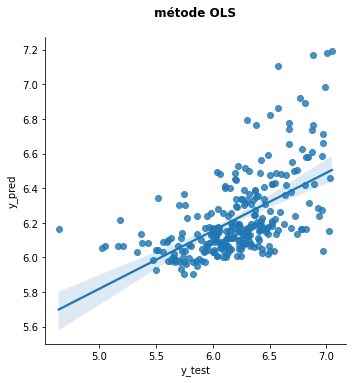

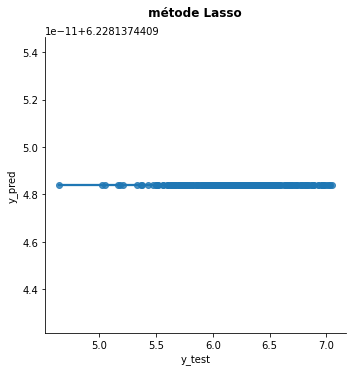

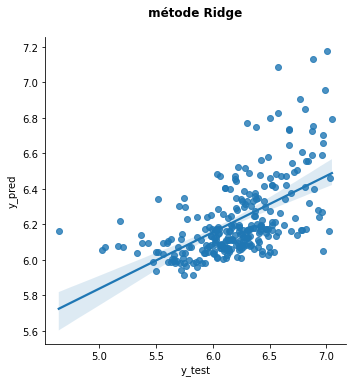

In [22]:
graph( {'OLS': LinearRegression(),
          'Lasso': Lasso(),
          'Ridge': Ridge()},X_train_log, X_test_log, y_train_log, y_test_log)

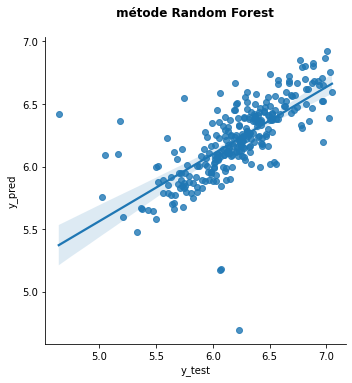

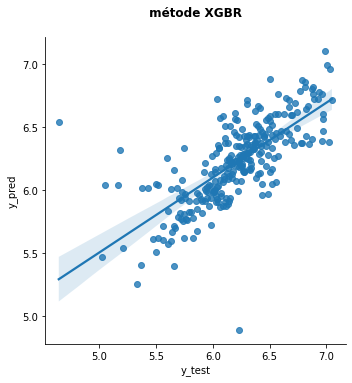

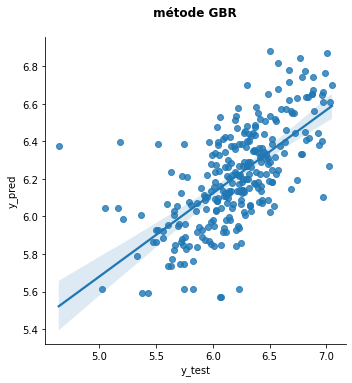

In [23]:
graph( {'Random Forest': RandomForestRegressor(),
          'XGBR': XGBRegressor(),
          'GBR':GradientBoostingRegressor() },X_train_log, X_test_log, y_train_log, y_test_log)

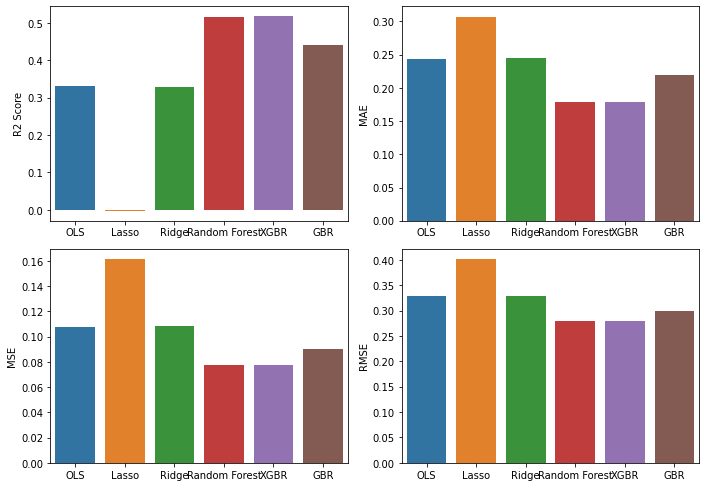

In [24]:
# barplot recapulative pour les resultats obtenus 

plt.subplots(figsize=(10, 10))

for index, column in enumerate(baseline_ENG.columns):
    plt.subplot(3, 2, index+1)
    sns.barplot(x=baseline_ENG.index, y=column, data=baseline_ENG)
plt.tight_layout()
plt.show()

### Optimisation des models

### Recherche des hyperparamètres GridSearchCV

GridSearch est une approche de réglage des paramètres qui permettra de construire et d'évaluer méthodiquement un modèle pour chaque combinaison de paramètres d'algorithme spécifiés dans une grille.



La fonction GridSearchCV permet de parcourir des hyperparamètres prédéfinis et d'ajuster l'estimateur (modèle) au jeu d'entraînement. Ainsi, à la fin, nous pouvons sélectionner les meilleurs paramètres parmi les répertoriés.

Donc, nous transmettons des valeurs prédéfinies pour les hyperparamètres à la fonction GridSearchCV en définissant un dictionnaire dans lequel nous mettions un hyperparamètre particulier ainsi que les valeurs qu'il peut prendre c
Il faut signaler que le reste des hyperparamètres non-définis utiliseront leurs valeurs par défault.

GridSearchCV essaie toutes les combinaisons des valeurs passées dans le dictionnaire et évalue le modèle pour chaque combinaison à l'aide de la méthode de validation croisée (CV). Par conséquent, après d'avoir utilisé cette fonction, nous obtenons une précision/perte pour chaque combinaison d'hyperparamètres et nous pouvons choisir celui avec les meilleures performances.



- **Estimation par une régression par la méthode Lasso**


Hyperparamètre : Estimation de alpha

In [25]:
lasso_params = {'alpha' : np.array([10, 1, 0.1, 0.02, 0.01, 0.005, 0.001, 0.0005])}

grid_lasso = GridSearchCV(Lasso(), param_grid=lasso_params,scoring='r2', cv= 10)
grid_lasso.fit(X_train_log, y_train_log)
grid_lasso.best_estimator_
print(f'Meilleur(s) hyperparamètre(s) sur le jeu d\'entraînement:',grid_lasso.best_params_)
print(f'Meilleur score sur le jeu d\'entraînement::',grid_lasso.best_score_)


Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'alpha': 0.0005}
Meilleur score sur le jeu d'entraînement:: 0.34648463146782515


- **Estimation par la méthode Régression Ridge**


Hyperparamètre : Estimation de alpha

In [26]:
ridge_params = {'alpha': np.logspace(-5, 5, 20)}

grid_ridge = GridSearchCV(Ridge(), param_grid=ridge_params, cv= 10,scoring='r2')
grid_ridge.fit(X_train_log, y_train_log)
grid_ridge.best_estimator_
print(f'Meilleur(s) hyperparamètre(s) sur le jeu d\'entraînement:',grid_ridge.best_params_)
print(f'Meilleur score sur le jeu d\'entraînement::',grid_ridge.best_score_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'alpha': 1.8329807108324339}
Meilleur score sur le jeu d'entraînement:: 0.34819026108958007


- **Estimation par une régression par la méthode Random Forest**


Hyperparamètre : Estimation de max_depth, n_estimators, min_samples_leaf et min_samples_split

- n_estimators : nombre d’arbres à considérer pour le ramdom forest

- max_depth : nombre maximum de niveaux dans chaque arbre de décision (profondeur) sinon si on ne donne pas de limitation, le processus peut etre long

- min_samples_leaf = nombre minimum d'observations pour créer une feuille (limitation implicite de la profondeur) (limite pour ne pas avoir de feuille trop petite et avoir du sur-apprentissage).

- min_samples_split = nombre minimum d'observations dans un noeud avant la division du noeud



In [27]:
rfr_params = {'bootstrap': [True, False],
              'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10],
              'n_estimators': [1000, 1200, 1400, 1600, 1800, 2000]}

random_rfr = RandomizedSearchCV(RandomForestRegressor(), param_distributions=rfr_params, cv= 10,scoring='r2')
random_rfr.fit(X_train_log, y_train_log)
random_rfr.best_estimator_
random_rfr.best_score_
print(f'Meilleur(s) hyperparamètre(s) sur le jeu d\'entraînement:',random_rfr.best_estimator_)
print(f'Meilleur score sur le jeu d\'entraînement:',random_rfr.best_score_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: RandomForestRegressor(max_depth=70, max_features='sqrt', min_samples_split=5,
                      n_estimators=2000)
Meilleur score sur le jeu d'entraînement: 0.5363643223121782


-**Estimation par une régression par la méthode XGBoost**


Hyperparamètre : n_estimators et max_depth

- n_estimators : nombre d'arbres de décision

- max_depth : nombre maximum de niveaux dans chaque arbre de décision

In [28]:
XGB_params = {'n_estimators':  np.arange(50, 300, 20),  #nombre d'arbres de décision #(10,100,10)
              'max_depth': np.arange(20, 50, 5)} #nombre maximum de niveaux dans chaque arbre de décision

grid_XGB = GridSearchCV(XGBRegressor(), param_grid=XGB_params, cv= 5, scoring='r2')
grid_XGB.fit(X_train_log, y_train_log)
grid_XGB.best_estimator_
print(f'Meilleur(s) hyperparamètre(s) sur le jeu d\'entraînement:',grid_XGB.best_estimator_)
print(f'Meilleur score sur le jeu d\'entraînement::',grid_XGB.best_score_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=20, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=290, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
Meilleur score sur le jeu d'entraînement:: 0.4610922688068638


-**Estimation par une régression par la méthode GradientBoostingRegressor**


Hyperparamètre : 
- learning_rate:Le taux d'apprentissage réduit la contribution de chaque arbre
- n_estimators : nombre d'arbres de décision
- subsample :La fraction d'échantillons à utiliser pour ajuster les apprenants de base individuels.
- max_depth : nombre maximum de niveaux dans chaque arbre de décision

In [29]:
GBR_params = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,500,1000, 1500],
                  'max_depth'    : [4,6,8,10]
                 }

grid_GBR = GridSearchCV(GradientBoostingRegressor(), param_grid=GBR_params, cv= 5,scoring='r2')
grid_GBR.fit(X_train_log, y_train_log)
grid_GBR.best_estimator_
print(f'Meilleur(s) hyperparamètre(s) sur le jeu d\'entraînement:',grid_GBR.best_estimator_)
print(f'Meilleur score sur le jeu d\'entraînement::',grid_GBR.best_score_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=500,
                          subsample=0.1)
Meilleur score sur le jeu d'entraînement:: 0.4582379250370813


- les models optimiser à utiliser 

In [92]:

model2 = {'Linear' : LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
          'Lasso' : Lasso(alpha=0.0005),
           'Ridge' : Ridge(alpha=1.83),
           'Random_Forest' : RandomForestRegressor(max_depth=20, min_samples_leaf=2, n_estimators=1600),
           'XGBR': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=20, min_child_weight=1,
             monotone_constraints='()', n_estimators=290, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None),
         'GradientBoost':GradientBoostingRegressor(learning_rate=0.03, max_depth=10, subsample=0.2) }

In [116]:
optimize_ENG = test( model2,X_train_log, X_test_log, y_train_log, y_test_log)
optimize_ENG.round(4)

,R2 Score,MAE,MSE,RMSE,Erreur moy,Durée(sec)
Linear,0.3320,0.2441,0.1078,0.3283,0.2441,0.0080
Lasso,0.3315,0.2445,0.1078,0.3284,0.2445,0.0080
Ridge,0.3281,0.2452,0.1084,0.3292,0.2452,0.0160
Random_Forest,0.5256,0.1833,0.0765,0.2766,0.1833,14.9766
XGBR,0.5349,0.1614,0.0750,0.2739,0.1614,0.8321
GradientBoost,0.5316,0.1966,0.0756,0.2749,0.1966,0.2871


In [117]:
scores_ENG = pd.concat([baseline_ENG, optimize_ENG], keys=['Baseline', 'Optimize'])
scores_ENG.round(4)

R2 Score     MAE     MSE    RMSE  Erreur moy  \
Baseline OLS              0.3320  0.2441  0.1078  0.3283      0.2441   
         Lasso           -0.0033  0.3071  0.1618  0.4023      0.3071   
         Ridge            0.3297  0.2449  0.1081  0.3288      0.2449   
         Random Forest    0.5353  0.1750  0.0750  0.2738      0.1750   
         XGBR             0.5184  0.1779  0.0777  0.2787      0.1779   
         GBR              0.4471  0.2185  0.0892  0.2987      0.2185   
Optimize Linear           0.3320  0.2441  0.1078  0.3283      0.2441   
         Lasso            0.3315  0.2445  0.1078  0.3284      0.2445   
         Ridge            0.3281  0.2452  0.1084  0.3292      0.2452   
         Random_Forest    0.5256  0.1833  0.0765  0.2766      0.1833   
         XGBR             0.5349  0.1614  0.0750  0.2739      0.1614   
         GradientBoost    0.5316  0.1966  0.0756  0.2749      0.1966   

                        Durée(sec)  
Baseline OLS                0.0162  
         Lasso              0.0080  
         Ridge              0.0080  
         Random Forest      0.9874  
         XGBR               0.3365  
         GBR                0.4439  
Optimize Linear             0.0080  
         Lasso              0.0080  
         Ridge              0.0160  
         Random_Forest     14.9766  
         XGBR               0.8321  
         GradientBoost      0.2871

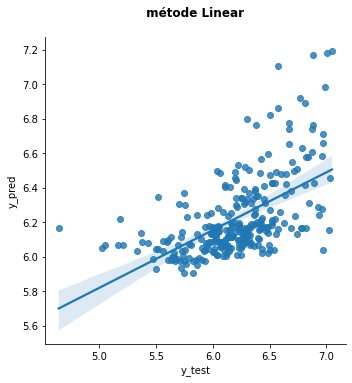

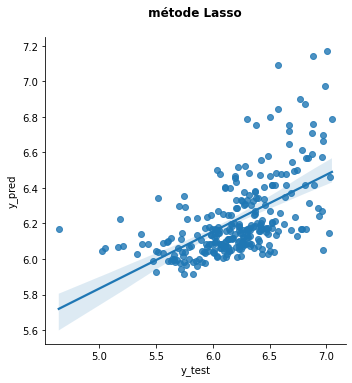

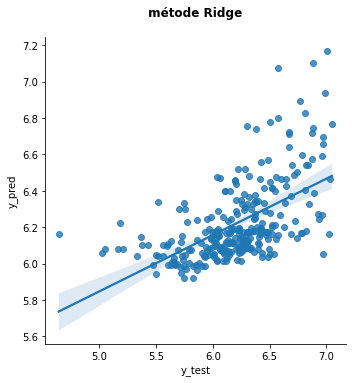

In [33]:
graph( {'Linear' : LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
          'Lasso' : Lasso(alpha=0.0005),
           'Ridge' : Ridge(alpha=1.83)},X_train_log, X_test_log, y_train_log, y_test_log)

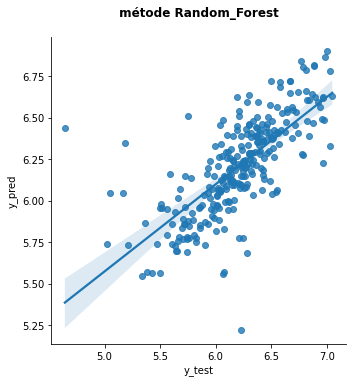

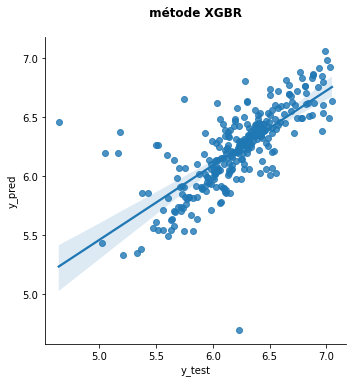

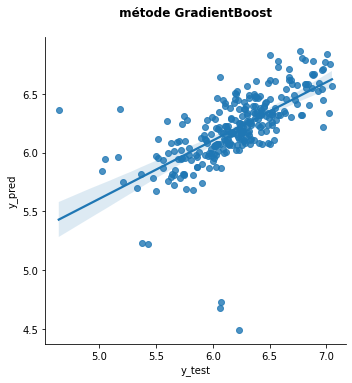

In [34]:
graph( {'Random_Forest' : RandomForestRegressor(max_depth=20, min_samples_leaf=2, n_estimators=1600),
           'XGBR': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=20, min_child_weight=1,
             monotone_constraints='()', n_estimators=290, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None),
         'GradientBoost':GradientBoostingRegressor(learning_rate=0.03, max_depth=10, subsample=0.2)},X_train_log, X_test_log, y_train_log, y_test_log)

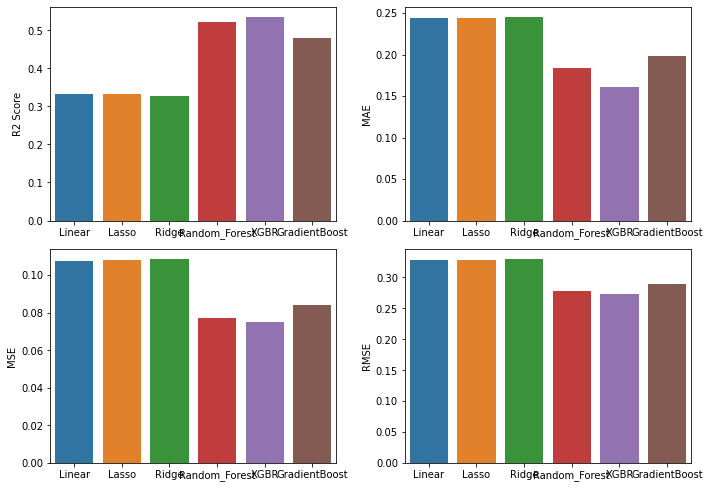

In [35]:
plt.subplots(figsize=(10, 10))

for index, column in enumerate(optimize_ENG.columns):
    plt.subplot(3, 2, index+1)
    sns.barplot(x=optimize_ENG.index, y=column, data=optimize_ENG)
plt.tight_layout()
plt.show()

### Prédiction TotalGHGEmissions

In [36]:
# Vecteur y

#On conserve les 2 cibles une transformée et l'autre non pour voir son efficacité sur la performance des modèles

# Analyse de la target 'TotalGHGEmissions' non transformée
y_GHG = df['TotalGHGEmissions']
y_GHG.shape

(1402,)

In [37]:
# Analyse de la target 'SiteEnergyUseWNLog' transformée en logarithme
y_GHGlog = df['TotalGHGEmissionsLog']
y_GHGlog.shape

(1402,)

In [38]:
# Découpage du jeu de données en train set et test set cilble transformée 'SiteEnergyUseLog'
X_train_log, X_test_log, y_train_GHGlog, y_test_GHGlog = train_test_split(
    X, y_GHGlog, test_size=0.2, random_state=42)


In [118]:
baseline_GHG = test( models,X_train_log, X_test_log, y_train_GHGlog, y_test_GHGlog)
baseline_GHG

,R2 Score,MAE,MSE,RMSE,Erreur moy,Durée(sec)
OLS,0.120460,0.377647,0.211247,0.459616,0.377647,0.008013
Lasso,-0.016804,0.400893,0.244215,0.494181,0.400893,0.008005
Ridge,0.117288,0.378469,0.212009,0.460444,0.378469,0.016001
Random Forest,0.499844,0.254550,0.120127,0.346593,0.254550,1.684012
XGBR,0.427668,0.252948,0.137462,0.370759,0.252948,0.680494
GBR,0.315953,0.323251,0.164293,0.405331,0.323251,0.437201


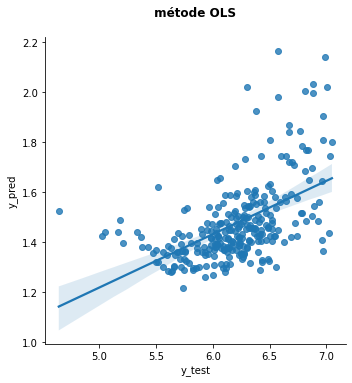

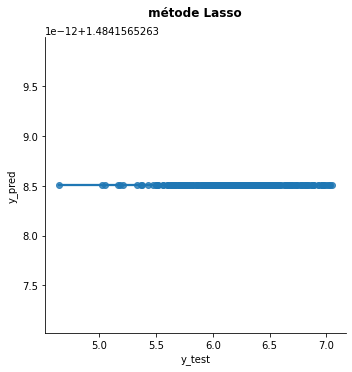

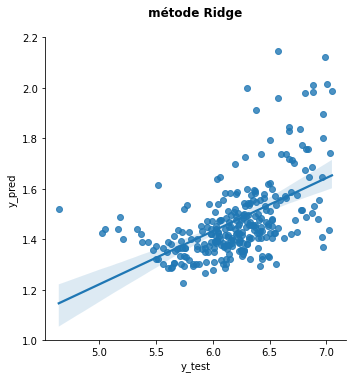

In [40]:
graph( {'OLS': LinearRegression(),
          'Lasso': Lasso(),
          'Ridge': Ridge()},X_train_log, X_test_log, y_train_GHGlog, y_test_GHGlog)

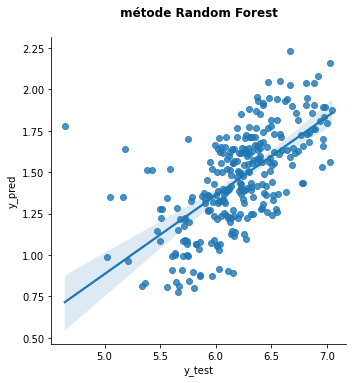

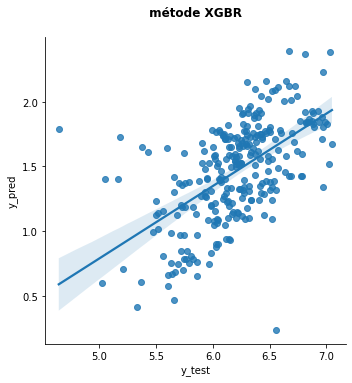

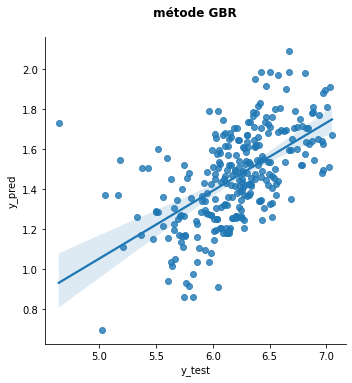

In [41]:
graph( {'Random Forest': RandomForestRegressor(),
          'XGBR': XGBRegressor(),
          'GBR':GradientBoostingRegressor() },X_train_log, X_test_log, y_train_GHGlog, y_test_GHGlog)

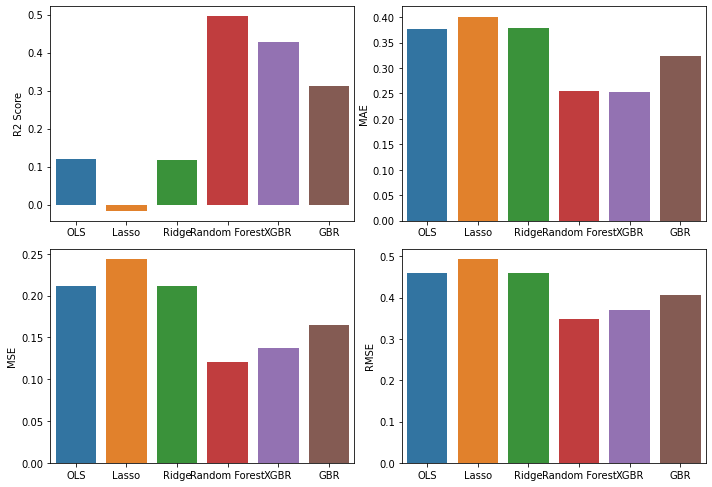

In [42]:
plt.subplots(figsize=(10, 10))

for index, column in enumerate(baseline_GHG.columns):
    plt.subplot(3, 2, index+1)
    sns.barplot(x=baseline_GHG.index, y=column, data=baseline_GHG)
plt.tight_layout()
plt.show()

### Recherche des hyperparamètres GridSearchCV

- **Estimation par une régression par la méthode Lasso**


Hyperparamètre : Estimation de alpha

In [43]:
lassoGHG_params = {'alpha' : np.array([10, 1, 0.1, 0.02, 0.01, 0.005, 0.001, 0.0005])}

gridGHG_lasso = GridSearchCV(Lasso(), param_grid=lassoGHG_params,scoring='r2', cv= 10)
gridGHG_lasso.fit(X_train_log, y_train_GHGlog)
gridGHG_lasso.best_estimator_
print(f'Meilleur(s) hyperparamètre(s) sur le jeu d\'entraînement:',gridGHG_lasso.best_params_)
print(f'Meilleur score sur le jeu d\'entraînement::',gridGHG_lasso.best_score_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'alpha': 0.001}
Meilleur score sur le jeu d'entraînement:: 0.129004131648982


- **Estimation par la méthode Régression Ridge**


Hyperparamètre : Estimation de alpha

In [44]:
ridgeGHG_params = {'alpha': np.logspace(-5, 5, 20)}

gridGHG_ridge = GridSearchCV(Ridge(), param_grid=ridgeGHG_params, cv= 10,scoring='r2')
gridGHG_ridge.fit(X_train_log, y_train_GHGlog)
gridGHG_ridge.best_estimator_
print(f'Meilleur(s) hyperparamètre(s) sur le jeu d\'entraînement:',gridGHG_ridge.best_params_)
print(f'Meilleur score sur le jeu d\'entraînement::',gridGHG_ridge.best_score_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: {'alpha': 1.8329807108324339}
Meilleur score sur le jeu d'entraînement:: 0.12793724346316457


- **Estimation par une régression par la méthode Random Forest**


Hyperparamètre : Estimation de max_depth, n_estimators, min_samples_leaf et min_samples_split

- n_estimators : nombre d’arbres à considérer pour le ramdom forest

- max_depth : nombre maximum de niveaux dans chaque arbre de décision (profondeur) sinon si on ne donne pas de limitation, le processus peut etre long

- min_samples_leaf = nombre minimum d'observations pour créer une feuille (limitation implicite de la profondeur) (limite pour ne pas avoir de feuille trop petite et avoir du sur-apprentissage).

- min_samples_split = nombre minimum d'observations dans un noeud avant la division du noeud



In [45]:
rFrGHG_params = {'bootstrap': [True, False],
              'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10],
              'n_estimators': [1000, 1200, 1400, 1600, 1800, 2000]}

random_rfrGHG = RandomizedSearchCV(RandomForestRegressor(), param_distributions=rFrGHG_params, cv= 10,scoring='r2')
random_rfrGHG.fit(X_train_log, y_train_GHGlog)
random_rfrGHG.best_estimator_
print(f'Meilleur(s) hyperparamètre(s) sur le jeu d\'entraînement:',random_rfrGHG.best_estimator_)
print(f'Meilleur score sur le jeu d\'entraînement:',random_rfrGHG.best_score_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: RandomForestRegressor(max_depth=20, n_estimators=1600)
Meilleur score sur le jeu d'entraînement: 0.4956122586327334


-**Estimation par une régression par la méthode XGBoost**


Hyperparamètre : n_estimators et max_depth

- n_estimators : nombre d'arbres de décision

- max_depth : nombre maximum de niveaux dans chaque arbre de décision

In [46]:
XGBGHG_params = {'n_estimators':  np.arange(50, 300, 20),  #nombre d'arbres de décision #(10,100,10)
              'max_depth': np.arange(20, 50, 5)} #nombre maximum de niveaux dans chaque arbre de décision

grid_XGBGHG = GridSearchCV(XGBRegressor(), param_grid=XGBGHG_params, cv= 5, scoring='r2')
grid_XGBGHG.fit(X_train_log, y_train_GHGlog)
grid_XGBGHG.best_estimator_
print(f'Meilleur(s) hyperparamètre(s) sur le jeu d\'entraînement:',grid_XGBGHG.best_estimator_)
print(f'Meilleur score sur le jeu d\'entraînement::',grid_XGBGHG.best_score_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=30, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=290, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
Meilleur score sur le jeu d'entraînement:: 0.3970422256148509


-**Estimation par une régression par la méthode GradientBoostingRegressor**


Hyperparamètre : 
- learning_rate:Le taux d'apprentissage réduit la contribution de chaque arbre
- n_estimators : nombre d'arbres de décision
- subsample :La fraction d'échantillons à utiliser pour ajuster les apprenants de base individuels.
- max_depth : nombre maximum de niveaux dans chaque arbre de décision

In [47]:
GBRGHG_params = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,500,1000, 1500],
                  'max_depth'    : [4,6,8,10]
                 }

grid_GBRGHG = GridSearchCV(GradientBoostingRegressor(), param_grid=GBRGHG_params, cv= 5,scoring='r2')
grid_GBRGHG.fit(X_train_log, y_train_GHGlog)
grid_GBRGHG.best_estimator_
print(f'Meilleur(s) hyperparamètre(s) sur le jeu d\'entraînement:',grid_GBRGHG.best_estimator_)
print(f'Meilleur score sur le jeu d\'entraînement::',grid_GBRGHG.best_score_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
                          subsample=0.5)
Meilleur score sur le jeu d'entraînement:: 0.4929178256987063


In [48]:
model3 = {'Linear' : LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
          'Lasso' : Lasso(alpha=0.001),
           'Ridge' : Ridge(alpha=1.83),
           'Random_Forest' : RandomForestRegressor(bootstrap=False, max_depth=70, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=10,
                      n_estimators=2000),
           'XGBR':  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=30, min_child_weight=1, 
             monotone_constraints='()', n_estimators=290, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None),
         'GradientBoost':GradientBoostingRegressor(learning_rate=0.03, max_depth=10, n_estimators=1000,subsample=0.5)}

In [119]:
optimize_GHG = test( model3,X_train_log, X_test_log, y_train_GHGlog, y_test_GHGlog)
optimize_GHG

,R2 Score,MAE,MSE,RMSE,Erreur moy,Durée(sec)
Linear,0.120460,0.377647,0.211247,0.459616,0.377647,0.008014
Lasso,0.121953,0.377413,0.210888,0.459225,0.377413,0.007998
Ridge,0.116343,0.378669,0.212235,0.460690,0.378669,0.016106
Random_Forest,0.408203,0.293742,0.142137,0.377011,0.293742,13.586125
XGBR,0.505129,0.225667,0.118857,0.344757,0.225667,1.193540
GradientBoost,0.545162,0.217390,0.109242,0.330518,0.217390,6.768866


In [120]:
scores_GHG = pd.concat([baseline_GHG, optimize_GHG], keys=['Baseline', 'Optimize'])
scores_GHG.round(4)

R2 Score     MAE     MSE    RMSE  Erreur moy  \
Baseline OLS              0.1205  0.3776  0.2112  0.4596      0.3776   
         Lasso           -0.0168  0.4009  0.2442  0.4942      0.4009   
         Ridge            0.1173  0.3785  0.2120  0.4604      0.3785   
         Random Forest    0.4998  0.2546  0.1201  0.3466      0.2546   
         XGBR             0.4277  0.2529  0.1375  0.3708      0.2529   
         GBR              0.3160  0.3233  0.1643  0.4053      0.3233   
Optimize Linear           0.1205  0.3776  0.2112  0.4596      0.3776   
         Lasso            0.1220  0.3774  0.2109  0.4592      0.3774   
         Ridge            0.1163  0.3787  0.2122  0.4607      0.3787   
         Random_Forest    0.4082  0.2937  0.1421  0.3770      0.2937   
         XGBR             0.5051  0.2257  0.1189  0.3448      0.2257   
         GradientBoost    0.5452  0.2174  0.1092  0.3305      0.2174   

                        Durée(sec)  
Baseline OLS                0.0080  
         Lasso              0.0080  
         Ridge              0.0160  
         Random Forest      1.6840  
         XGBR               0.6805  
         GBR                0.4372  
Optimize Linear             0.0080  
         Lasso              0.0080  
         Ridge              0.0161  
         Random_Forest     13.5861  
         XGBR               1.1935  
         GradientBoost      6.7689

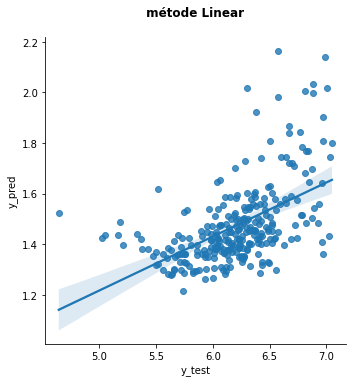

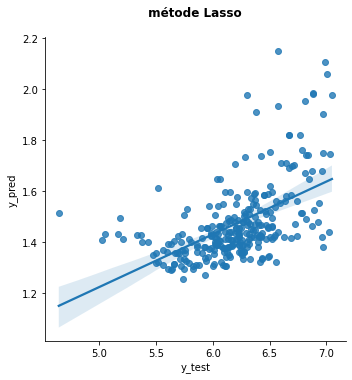

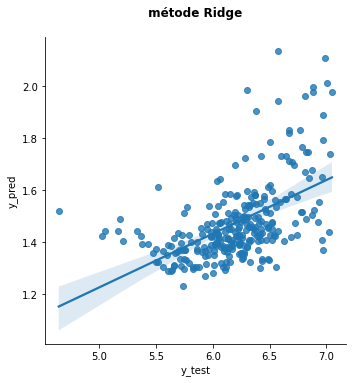

In [51]:
graph( {'Linear' : LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
          'Lasso' : Lasso(alpha=0.001),
           'Ridge' : Ridge(alpha=1.83)},X_train_log, X_test_log, y_train_GHGlog, y_test_GHGlog)

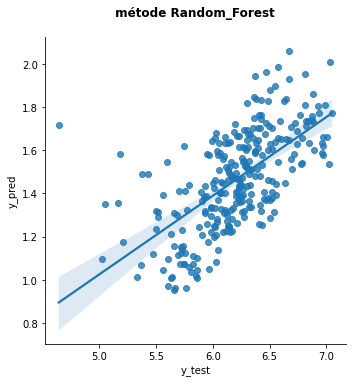

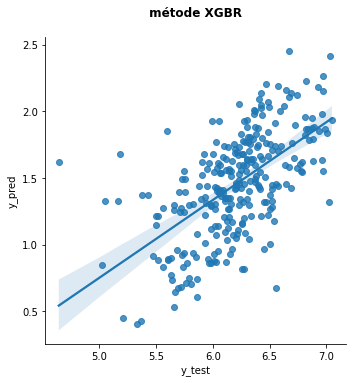

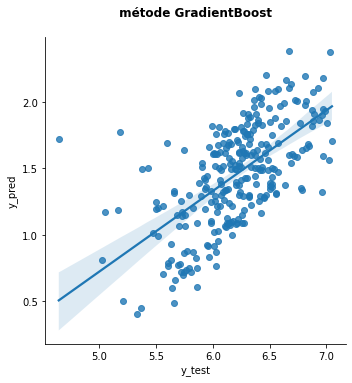

In [52]:
graph( {'Random_Forest' : RandomForestRegressor(bootstrap=False, max_depth=70, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=10,
                      n_estimators=2000),
           'XGBR':  XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=30, min_child_weight=1, 
             monotone_constraints='()', n_estimators=290, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None),
         'GradientBoost':GradientBoostingRegressor(learning_rate=0.03, max_depth=10, n_estimators=1000,subsample=0.5)},X_train_log, X_test_log, y_train_GHGlog, y_test_GHGlog)

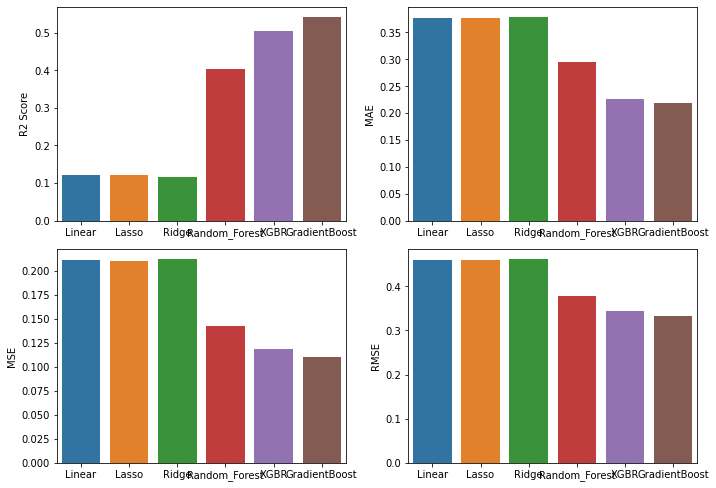

In [53]:
plt.subplots(figsize=(10, 10))

for index, column in enumerate(optimize_GHG.columns):
    plt.subplot(3, 2, index+1)
    sns.barplot(x=optimize_GHG.index, y=column, data=optimize_GHG)
plt.tight_layout()
plt.show()

### conclusion 

les modeles les plus pertinants sont: 

- XGBRegressor pour la variable  SiteEnergyUse(kBtu)
- GradientBoostingRegressor pour la variable TotalGHGEmissions

### Impact du score EnergyStar 

Nous allons mesurer l'intérêt de l'EnergyStarScore on ajoutant ce derniers a nos variables et voir par la suite son effet sur la modalisation 

In [54]:
# Suppression Variables cibles
# Suppression de la variable 'ENERGYSTARScore'
cols_num2=['Latitude',
 'Longitude',
 'BuildingAge',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFABuilding(s)',
 'TotalUseTypesCount',
 'TauxParkingGFA','ENERGYSTARScore']

In [55]:
# Matrice X
X = df[cols_cat+cols_num2]
X.shape

(1402, 14)

### Prédiction SiteEnergyUse(kBtu)
Après avoir bien préparé les données, il est désormais possible de prédire la consommation d'un bâtiment par différents modèles de machine learning, les comparer et ainsi choisir le plus performant et le mieux adapté à nos données.

In [56]:
# Vecteur y

#On conserve les 2 cibles une transformée et l'autre non pour voir son efficacité sur la performance des modèles
# Analyse de la target 'SiteEnergyUseLog' transformée en logarithme
y_log_engscor = df['SiteEnergyUseLog']
y_log_engscor.shape

(1402,)

In [57]:
 # Encodage  des variables qualitatives
# Convertir une variable catégorielle en variables factices/indicatrices avec pandas.get_dummies
#X=pd.get_dummies(data=X, columns=cols_cat)

  # Standardisation des variables quantitatives

# Jeu de la target de consommation d'énergie non transformée en log10
scaler_minmax = MinMaxScaler()
X[cols_num]= scaler_rob.fit_transform(X[cols_num].copy(deep=True))

X.shape

(1402, 14)

In [58]:
target_encoder = TargetEncoder()
X[cols_cat] = target_encoder.fit_transform(
    X[cols_cat], y_log_engscor)
X[cols_cat] = target_encoder.transform(X[cols_cat])

In [59]:
# Découpage du jeu de données en train set et test set cilble transformée 'SiteEnergyUseLog'
X_train_log_engscor, X_test_log_engscor, y_train_log_engscor, y_test_log_engscor = train_test_split(
    X, y_log_engscor, test_size=0.2, random_state=42)

In [121]:
model_ENG_engscor={'XGBR': XGBRegressor()}
baseline_ENG_engscor = test( model_ENG_engscor,X_train_log_engscor, X_test_log_engscor, y_train_log_engscor, y_test_log_engscor)
baseline_ENG_engscor

,R2 Score,MAE,MSE,RMSE,Erreur moy,Durée(sec)
XGBR,0.52847,0.156859,0.076068,0.275804,0.156859,0.507887


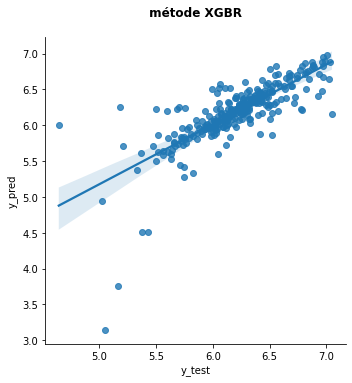

In [61]:
graph( model_ENG_engscor,X_train_log_engscor, X_test_log_engscor, y_train_log_engscor, y_test_log_engscor)

- **Estimation par une régression par la méthode XGBoost**

In [62]:
XGB_params_engscor = {'n_estimators':  np.arange(50, 300, 20),  #nombre d'arbres de décision #(10,100,10)
              'max_depth': np.arange(20, 50, 5)} #nombre maximum de niveaux dans chaque arbre de décision

grid_XGB_engscor  = GridSearchCV(XGBRegressor(), param_grid=XGB_params_engscor , cv= 5, scoring='r2')
grid_XGB_engscor .fit(X_train_log_engscor,y_train_log_engscor)
grid_XGB_engscor .best_estimator_
print(f'Meilleur(s) hyperparamètre(s) sur le jeu d\'entraînement:',grid_XGB_engscor .best_estimator_)
print(f'Meilleur score sur le jeu d\'entraînement::',grid_XGB_engscor .best_score_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=20, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=290, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
Meilleur score sur le jeu d'entraînement:: 0.569465365387799


In [63]:
model_ENG_engscor_opt={'XGBR': XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=20, min_child_weight=1,
             monotone_constraints='()', n_estimators=290, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)}

In [122]:
optimize_ENG_engscor = test( model_ENG_engscor_opt,X_train_log_engscor, X_test_log_engscor, y_train_log_engscor, y_test_log_engscor)
optimize_ENG_engscor

,R2 Score,MAE,MSE,RMSE,Erreur moy,Durée(sec)
XGBR,0.599512,0.150619,0.064607,0.25418,0.150619,0.850319


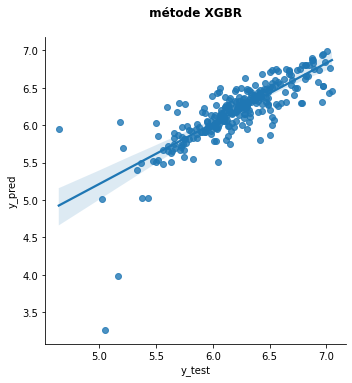

In [65]:
graph( model_ENG_engscor_opt,X_train_log_engscor, X_test_log_engscor, y_train_log_engscor, y_test_log_engscor)

In [123]:
scores_ENG_engscor = pd.concat([baseline_ENG_engscor, optimize_ENG_engscor], keys=['Baseline', 'Optimize'])
scores_ENG_engscor.round(4)

,,R2 Score,MAE,MSE,RMSE,Erreur moy,Durée(sec)
Baseline,XGBR,0.5285,0.1569,0.0761,0.2758,0.1569,0.5079
Optimize,XGBR,0.5995,0.1506,0.0646,0.2542,0.1506,0.8503


les scores nous indiquent que l'ajout de la variable ENERGYSTARScore améliore la prédiction  modèle

#### Importance des variables | Features importance
A partir du meilleur résultat après optimisation, nous allons reconstruire un modèle avec les meilleurs paramètres obtenus.

Ensuite nous allons analyser quelles sont les variables les plus importantes pour ce modèle.

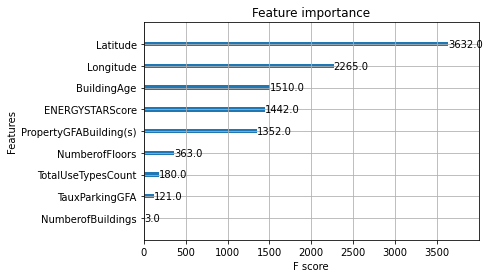

In [68]:
# Amélioration qui peut être effectuée : choix précis des variables

xgb.plot_importance(XGB_engscor, max_num_features=10)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

### Prédiction TotalGHGEmissions avec ENERGYSTARScore 

In [69]:
# Vecteur y

#On conserve les 2 cibles une transformée et l'autre non pour voir son efficacité sur la performance des modèles
# Analyse de la target 'TotalGHGEmissionsLog' transformée en logarithme
y_log_ghgscor = df['TotalGHGEmissionsLog']
y_log_ghgscor.shape

(1402,)

In [70]:
# Découpage du jeu de données en train set et test set cilble transformée 'SiteEnergyUseLog'
X_train_log_ghgscor, X_test_log_ghgscor, y_train_log_ghgscor, y_test_log_ghgscor = train_test_split(
    X, y_log_ghgscor, test_size=0.2, random_state=42)

In [124]:
# prédiction avec 'GBR':GradientBoostingRegressor()
model_ghgscor={'GBR':GradientBoostingRegressor()}
baseline_ghgscor = test(model_ghgscor,X_train_log_ghgscor, X_test_log_ghgscor, y_train_log_ghgscor, y_test_log_ghgscor)
baseline_ghgscor

,R2 Score,MAE,MSE,RMSE,Erreur moy,Durée(sec)
GBR,0.392335,0.305834,0.145948,0.382032,0.305834,0.578674


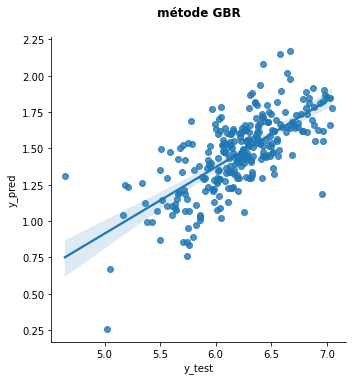

In [72]:
graph( model_ghgscor,X_train_log_ghgscor, X_test_log_ghgscor, y_train_log_ghgscor, y_test_log_ghgscor)

In [73]:
GBRghgscor_params = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,500,1000, 1500],
                  'max_depth'    : [4,6,8,10]
                 }

grid_GBRghgscor = GridSearchCV(GradientBoostingRegressor(), param_grid=GBRghgscor_params, cv= 5,scoring='r2')
grid_GBRghgscor.fit(X_train_log_ghgscor, y_train_log_ghgscor)
grid_GBRghgscor.best_estimator_
print(f'Meilleur(s) hyperparamètre(s) sur le jeu d\'entraînement:',grid_GBRghgscor.best_estimator_)
print(f'Meilleur score sur le jeu d\'entraînement::',grid_GBRghgscor.best_score_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement: GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
                          subsample=0.5)
Meilleur score sur le jeu d'entraînement:: 0.5488719233508972


In [130]:
model_ENG_GBRghgscor_opt={'GBR': GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1500,subsample=0.5)}

In [131]:
optimize_ghgscor = test(model_ENG_GBRghgscor_opt,X_train_log_ghgscor, X_test_log_ghgscor, y_train_log_ghgscor, y_test_log_ghgscor)
optimize_ghgscor

,R2 Score,MAE,MSE,RMSE,Erreur moy,Durée(sec)
GBR,0.62232,0.208065,0.090711,0.301182,0.208065,9.586941


In [132]:
scores_ENG_ghgscor = pd.concat([baseline_ghgscor, optimize_ghgscor], keys=['Baseline', 'Optimize'])
scores_ENG_ghgscor.round(4)

,,R2 Score,MAE,MSE,RMSE,Erreur moy,Durée(sec)
Baseline,GBR,0.3923,0.3058,0.1459,0.3820,0.3058,0.5787
Optimize,GBR,0.6223,0.2081,0.0907,0.3012,0.2081,9.5869


### Variable Importance

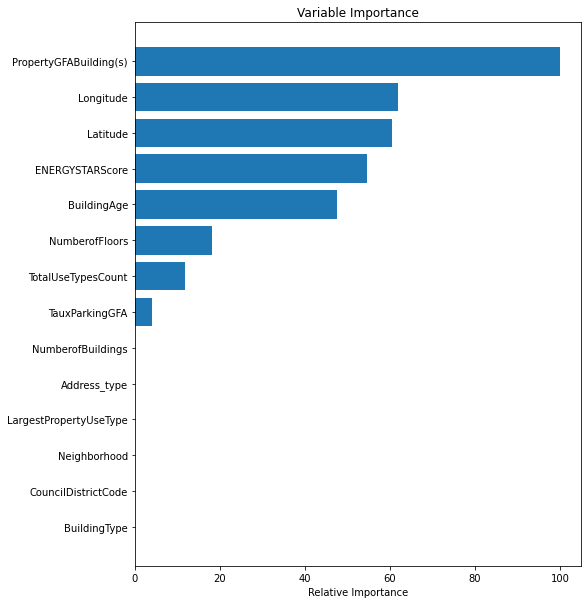

In [155]:
reg=GradientBoostingRegressor(learning_rate=0.01, max_depth=10, n_estimators=1500,subsample=0.5)
reg.fit(X_train_log_ghgscor, y_train_log_ghgscor)
feature_importance = reg.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_log_ghgscor.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

On peut noter que EnergyStarScore a un intérêt ici, on ce retrouve avec des models plus performant en prenant en compte EnergyStarScore.